<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-driven-science-and-engineering/01-svd/09_pca_truncation_and_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PCA:Truncation and Alignment

Deciding how many singular values to keep, i.e., where to truncate, is one of the most
important and contentious decisions when using the SVD. There are many factors, including
specifications on the desired rank of the system, the magnitude of noise, and the
distribution of the singular values.

Often, one truncates the SVD at a rank `r` that captures a
predetermined amount of the variance or energy in the original data, such as `90%` or `99%` truncation.

Other techniques involve
identifying “elbows” or “knees” in the singular value distribution, which may denote the
transition from singular values that represent important patterns from those that represent
noise.

Truncation may be viewed as a hard threshold on singular values, where values
larger than a threshold $\tau$ are kept, while remaining singular values are truncated.

In addition, the alignment of data significantly impacts the rank of the SVD approximation.

The SVD essentially relies on a separation of variables between the columns and rows
of a data matrix.

##Setup

In [1]:
import numpy as np
import scipy.io
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

##Noisy low-rank data

Let's artificially construct a rank-two
matrix and contaminate the data with Gaussian white noise. 

A de-noised and dimensionally
reduced matrix is then obtained using the threshold, as well as a truncation
keeping `90%` of the cumulative sum of singular values.

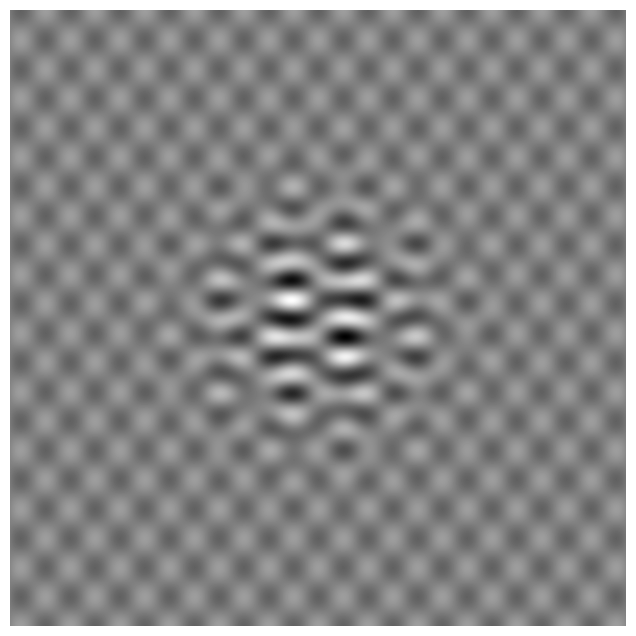

In [3]:
# Generate underlying low-rank data
t = np.arange(-3, 3, 0.01)

# Compute eigenfaces on mean-subtracted training data
U_true = np.array([np.cos(17 * t) * np.exp(-t ** 2), np.sin(11 * t)]).T
S_true = np.array([[2, 0], [0, 0.5]])
V_true = np.array([np.sin(5 * t) * np.exp(-t ** 2), np.cos(13 * t)]).T

X = U_true @ S_true @ V_true.T

plt.imshow(X)
plt.set_cmap('gray')
plt.axis('off')

plt.show()

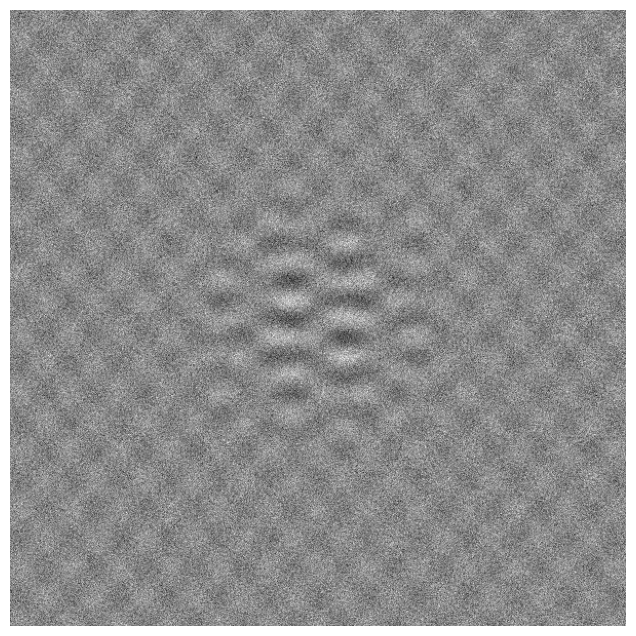

In [5]:
# Contaminate signal with noise
sigma = 1
X_noisy = X + sigma * np.random.randn(*X.shape)

plt.imshow(X_noisy)
plt.set_cmap('gray')
plt.axis('off')

plt.show()

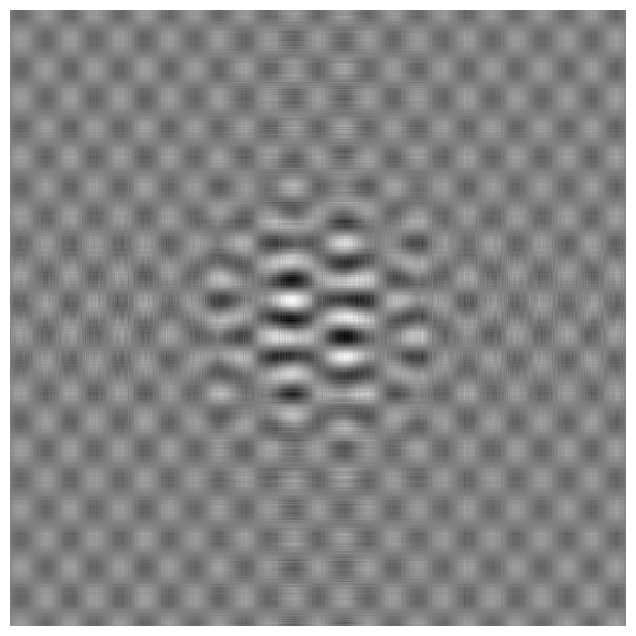

In [6]:
# Truncate using optimal hard threshold
U, S, VT = np.linalg.svd(X_noisy, full_matrices=0)

N = X_noisy.shape[0]
cuttoff = (4 / np.sqrt(3)) * np.sqrt(N) * sigma  # Hard threshold
r = np.max(np.where(S > cuttoff))                # Keep modes w/ S > cutoff

X_clean = U[:, : (r + 1)] @ np.diag(S[:(r + 1)]) @ VT[:(r + 1), :]

plt.imshow(X_clean)
plt.set_cmap('gray')
plt.axis('off')

plt.show()

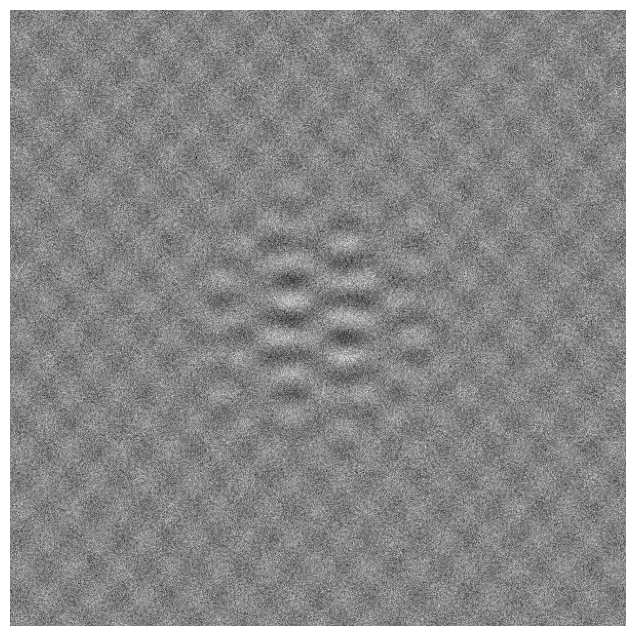

In [7]:
# Truncate to keep 90% of cumulative sum
cds = np.cumsum(S) / np.sum(S)     # Cumulative energy
r90 = np.min(np.where(cds > 0.90)) # Find r to keep 90% sum

X90 = U[:, : (r90 + 1)] @ np.diag(S[:(r90 + 1)]) @ VT[:(r90 + 1), :]

plt.imshow(X90)
plt.set_cmap('gray')
plt.axis('off')

plt.show()

It is clear that the hard threshold is
able to filter the noise more effectively.

Let's plot Singular Values.

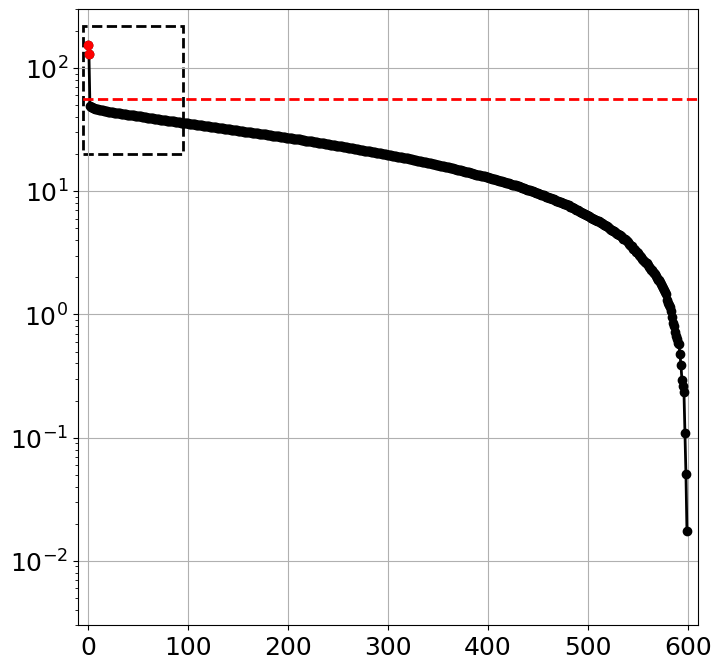

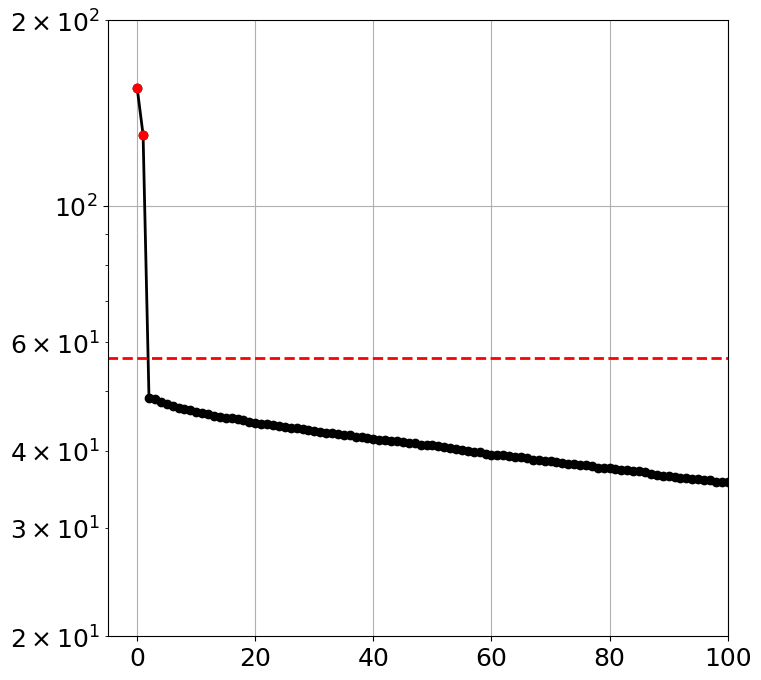

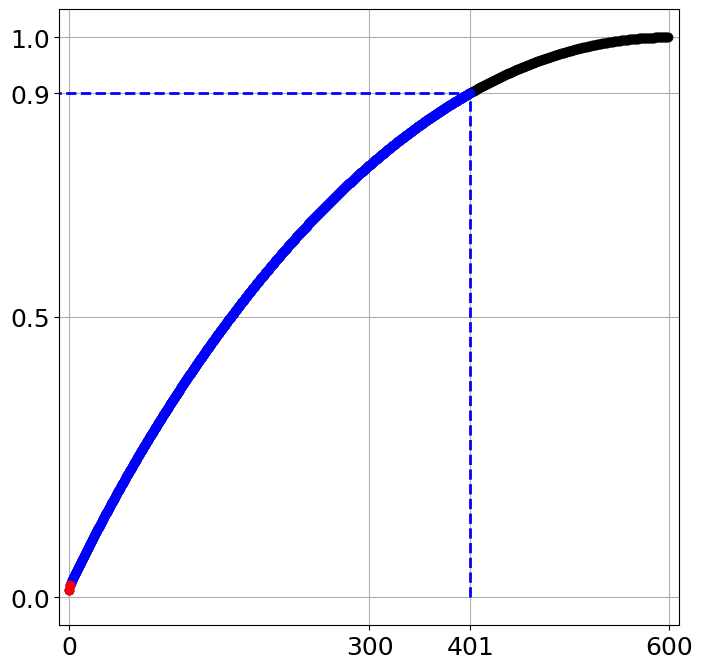

In [8]:
fig1,ax1 = plt.subplots(1)

ax1.semilogy(S,'-o', color='k', linewidth=2)
ax1.semilogy(np.diag(S[:(r+1)]),'o', color='r', linewidth=2)
ax1.plot(np.array([-20, N+20]),np.array([cuttoff, cuttoff]),'--', color='r', linewidth=2)
rect = patches.Rectangle((-5,20),100,200,linewidth=2,linestyle='--',facecolor='none',edgecolor='k')
ax1.add_patch(rect)
plt.xlim((-10,610))
plt.ylim((0.003,300))
ax1.grid()
plt.show()

fig2,ax2 = plt.subplots(1)

ax2.semilogy(S,'-o', color='k', linewidth=2)
ax2.semilogy(np.diag(S[:(r+1)]),'o', color='r', linewidth=2)
ax2.plot(np.array([-20, N+20]),np.array([cuttoff, cuttoff]),'--', color='r', linewidth=2)
plt.xlim((-5,100))
plt.ylim((20,200))
ax2.grid()
plt.show()

fig3,ax3 = plt.subplots(1)
ax3.plot(cds,'-o',color='k',linewidth=2)
ax3.plot(cds[:(r90+1)],'o',color='b',linewidth=2)
ax3.plot(cds[:(r+1)],'o',color='r',linewidth=2)
plt.xticks(np.array([0, 300, r90, 600]))
plt.yticks(np.array([0, 0.5, 0.9, 1]))
plt.xlim((-10,610))
ax3.plot(np.array([r90, r90, -10]),np.array([0, 0.9, 0.9]),'--',color='b',linewidth=2)

ax3.grid()
plt.show()

##Importance of Data Alignment

Using the eigenfaces library, we now attempt to approximately represent
an image that was not in the training data. 

At the beginning, we held back two individuals (the 37th and 38th people), and we now use one of their images as a test
image, $x_{test}$. 

We will see how well a rank-r SVD basis will approximate this image using
the following projection:

$$\tilde X_{test} = \tilde U \tilde U * X_{test}$$


The eigenface approximation is relatively poor for `r ≤ 200`, although for `r > 400` it
converges to a passable representation of the test image.



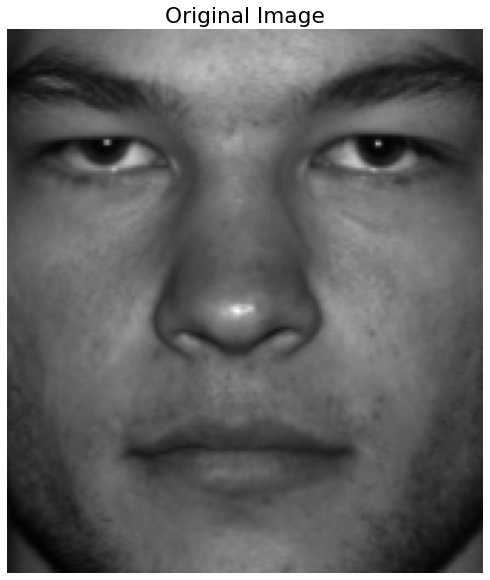

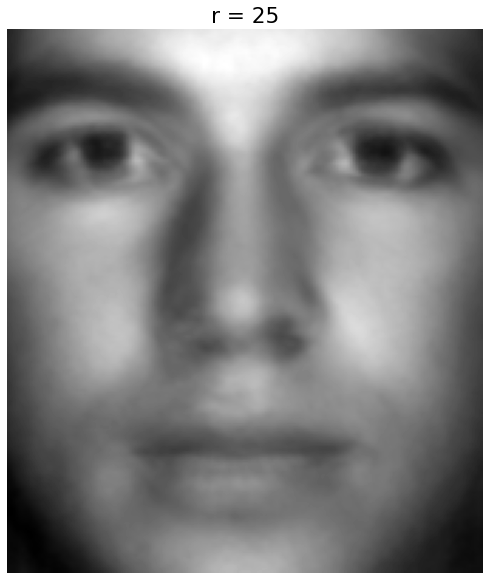

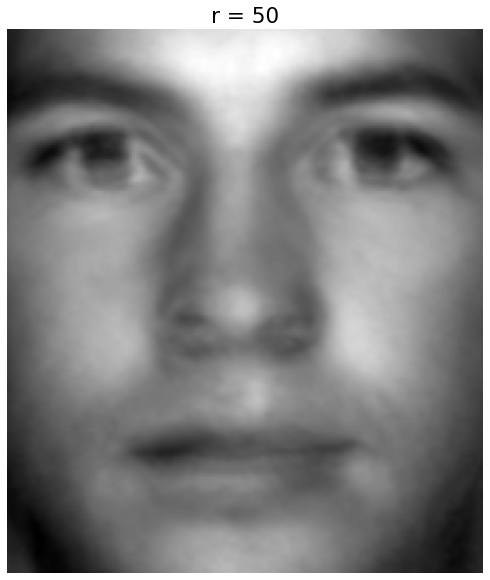

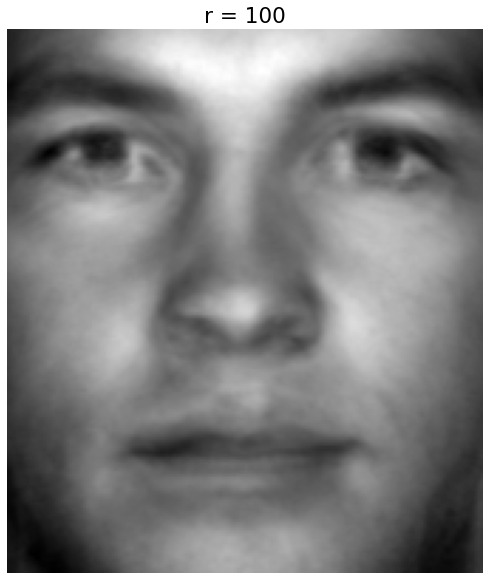

In [ ]:
# Now show eigenface reconstruction of image that was omitted from test set

test_face = faces[:, np.sum(nfaces[:36])]  # First face of person 37
plt.imshow(np.reshape(test_face, (m, n)).T)
plt.set_cmap('gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

test_face_ms = test_face - avg_face
# r_list = [25, 50, 100, 200, 400, 800, 1600]
r_list = [25, 50, 100]

for r in r_list:
  recon_face = avg_face + U[:, :r] @ U[:, :r].T @ test_face_ms
  img = plt.imshow(np.reshape(recon_face, (m, n)).T)
  img.set_cmap('gray')
  plt.title('r = ' + str(r))
  plt.axis('off')
  plt.show()

##Eigenface space

We further investigate the use of the eigenfaces as a coordinate system, defining an
eigenface space. 

By projecting an image x onto the first `r` PCA modes, we obtain a set
of coordinates in this space: $\tilde x = \tilde U∗x$.

Some principal components may capture the most
common features shared among all human faces, while other principal components will be
more useful for distinguishing between individuals. Additional principal components may
capture differences in lighting angles.

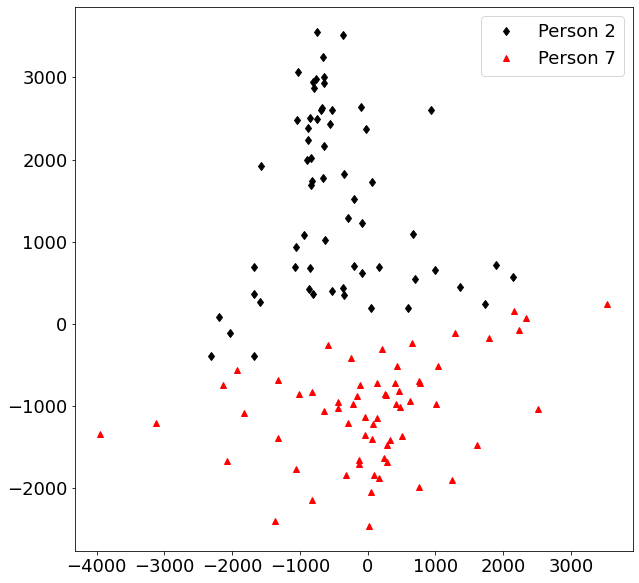

In [ ]:
# Project person 2 and 7 onto PC5 and PC6

num_p1 = 2  # Person number 2
num_p2 = 7  # Person number 7

P1 = faces[:, np.sum(nfaces[:(num_p1 -1)]): np.sum(nfaces[:num_p1])]
P2 = faces[:, np.sum(nfaces[:(num_p2 -1)]): np.sum(nfaces[:num_p2])]

P1 = P1 - np.tile(avg_face, (P1.shape[1], 1)).T
P2 = P2 - np.tile(avg_face, (P2.shape[1], 1)).T

# Project onto PCA modes 5 and 6
pca_modes = [5, 6]
pca_coords_p1 = U[:, pca_modes - np.ones_like(pca_modes)].T @ P1
pca_coords_p2 = U[:, pca_modes - np.ones_like(pca_modes)].T @ P2

plt.plot(pca_coords_p1[0, :], pca_coords_p1[1, :], "d", color="k", label="Person 2")
plt.plot(pca_coords_p2[0, :], pca_coords_p2[1, :], "^", color="r", label="Person 7")

plt.legend()
plt.show()

The coordinates of all 64 images
of two individuals projected onto the 5th and 6th principal components.

Images of the two individuals appear to be well separated in these coordinates. This is
the basis for image recognition and classification.